This notebook will look at the ellipses and the phase at the CODAR region.

In [4]:
import os
import datetime
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import subprocess as sp
from subprocess import Popen, PIPE
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import viz_tools, tidetools
from salishsea_tools.nowcast import research_VENUS

%matplotlib inline

In [5]:
sns.set_style('darkgrid')
sns.set_context('talk')
thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
grid = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
fB = nc.Dataset(grid)
bathy = fB.variables['Bathymetry'][:]
lons = fB.variables['nav_lon'][:]
lats = fB.variables['nav_lat'][:]

In [135]:
elpsM2 = nc.Dataset('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/CODAR/CODARM2param.nc')
elpsK1 = nc.Dataset('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/CODAR/CODARK1param.nc')

In [7]:
print phaK[81,28]

187.717328085


In [8]:
jmin = 379; jmax = 461; imin = 236; imax=321 
j = np.arange(jmin,jmax)
i = np.arange(imin,imax)
print len(i)

85


In [9]:
##Masking the values 
phaM= np.ma.masked_values(phaM,0)
phaK= np.ma.masked_values(phaK,270)

In [10]:
font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 20}
axisfont = {'family' : 'Arial',
    'weight' : 'light',
    'size'   : 16}

#Loading observations

In [11]:
A = sio.loadmat('/ocean/mhalvers/research/radar/SoG_codar_tide_ellipse_parameters.mat')
phaM2 = A['tide']['M2'][0,0]['fpha'][0,0]
phaM2 = np.ma.masked_where(np.isnan(phaM2), phaM2)
phaK1 = A['tide']['K1'][0,0]['fpha'][0,0]
phaK1 = np.ma.masked_where(np.isnan(phaK1), phaK1)
latall = A['tide']['lat'][0,0]
lonall = A['tide']['lon'][0,0]

##Map of ellipses

In [138]:
def plot_CODAR_ellipse_old(i, j, grid_E, grid_B, step, const, scale=8):
    
    #Load ellipse variables
    sema = grid_E.variables['Semi-Major'][:]
    semi = grid_E.variables['Semi-Minor'][:]
    inc = grid_E.variables['Inclination'][:]
    
    phi = 29
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    k = np.zeros((898, 398))
    m = np.zeros((898, 398))
    ex=10

    for q in np.arange(j[0]-ex, j[-1]+ex):
        for l in np.arange(i[0]-ex, i[-1]+ex):
            k[q, l] = q * np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
            m[q, l] = -q * np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.)

    for x in np.arange(0, len(i), step):
        for y in np.arange(0, len(j), step):
            if semi[y, x] > 0:
                thec = 'r'
            else:
                thec = 'b'
            ellsc = Ellipse(
                xy=(m[j[0]+y, i[0]+x], k[j[0]+y, i[0]+x]),
                width=scale * sema[y, x],
                height=scale * semi[y, x],
                angle=inc[y, x],
                color=thec)
            ax.add_artist(ellsc)
    bathy = grid_B.variables['Bathymetry'][:, :]

    contour_interval = [-0.01, 0.01]
    ax.contourf(m[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
                k[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
                bathy.data[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
                contour_interval,
                colors='black')
    ax.contour(m[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               k[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               bathy.data[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               [5],
               colors='black')
    viz_tools.set_aspect(ax) 
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)
    ell = Ellipse(xy=(m[430,326],k[430,326]),width = scale*0.5, height = scale*0.1, angle = -45,
                  color='g')
    ax.add_artist(ell)
    textscale = ax.text(m[425,321],k[425,321], '0.5 m/s', color='g', fontsize=12, fontweight='heavy')

    ax.set_ylim([470, 521])
    slope = (lats[j[-1],i[-1]]-lats[j[0],i[0]])/(k[j[-1],i[-1]]-k[j[0],i[0]])
    mylist = (k[j[-1],i[-1]]+(np.arange(48.52, 48.92, 0.1)-
                               lats[j[0],i[0]])/slope).tolist()
    labels = ['49', '49.1', '49.2', '49.3']
    ax.set_yticks(mylist)
    ax.set_yticklabels(labels)
   
    # x-axis in m, but labelled in longitude
    ax.set_xlim([50,100])
    slope = (lons[j[-1],i[-1]]-lons[j[0],i[0]])/(m[j[-1],i[-1]]-m[j[0],i[0]])
    mylist = (m[j[-1],i[-1]]+(np.arange(-123.86,-123.2,0.2)-
                            lons[j[0],i[0]])/slope).tolist()
    labels = ['123.75', '123.50', '123.25', '123']
    ax.set_xticks(mylist)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Latitude (degrees N)', **axisfont)
    ax.set_xlabel('Longitude (degrees W)', **axisfont)
    ax.set_xlabel('Longitude (degrees W)', **axisfont)

    ax.set_title('{} Surface tidal ellipses over the CODAR region'.format(const), **font)
    ax.tick_params(axis='both', which='major', labelsize=14)
    print 'red is counter clockwise'
    return fig

In [204]:
def plot_CODAR_ellipse(grid_E, grid_B, step, const, scale=8):
    
    #Load ellipse variables
    sema = grid_E.variables['Semi-Major'][:]
    semi = grid_E.variables['Semi-Minor'][:]
    inc = grid_E.variables['Inclination'][:]
    j = grid_E.variables['nav_lat'][:]
    i = grid_E.variables['nav_lon'][:]
    lons = fB.variables['nav_lon'][:]
    lats = fB.variables['nav_lat'][:]
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    viz_tools.set_aspect(ax) 
    print len(i)
    for x in np.arange(0, len(i), step):
        #print semi[0,x]
        for y in np.arange(0, len(j), step):
            #print (lats[j[y],i[x]], lons[j[y],i[x]])
            if semi[y, x] > 0:
                thec = 'r'
            else:
                thec = 'b'
            ellsc = Ellipse(
                xy=(lons[j[y],i[x]], lats[j[y],i[x]]),
                width=scale * sema[y, x],
                height=scale * semi[y, x],
                angle=inc[y, x],
                color=thec)
            #ax.plot(lons[j[y],i[x]], lats[j[y],i[x]], 'o')
            ax.add_artist(ellsc)
    contour_interval = [-0.01, 0.01]
    
    #Add scale ellipse
    ell = Ellipse(xy=(lons[430,326],lats[430,326]),width = scale*0.5, height = scale*0.5, angle = -45,
                  color='g')
    ax.add_artist(ell)
    textscale = ax.text(lons[425,321],lats[425,321], '0.5 m/s', color='g', fontsize=12, fontweight='heavy')
    ax.plot(-123-np.array([18.2,  13.7,  12])/60.,49+np.array([6.4,  8, 7.6])/60.,'--k',lw=4);
    viz_tools.plot_land_mask(ax, grid_B, coords='map')
    viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=5)
    viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=20)
    ax.set_xlim([lons[j[0], i[0]]-0.23, lons[j[-1], i[-1]]+0.2])
    ax.set_ylim([lats[j[0], i[0]]+0.1, lats[j[-1], i[-1]]+0.04])
    ax.set_ylabel('Latitude (degrees N)', **axisfont)
    ax.set_xlabel('Longitude (degrees W)', **axisfont)
    ax.set_xlabel('Longitude (degrees W)', **axisfont)

    ax.set_title('{} Surface tidal ellipses over the CODAR region'.format(const), **font)
    ax.tick_params(axis='both', which='major', labelsize=14)
    return fig

85


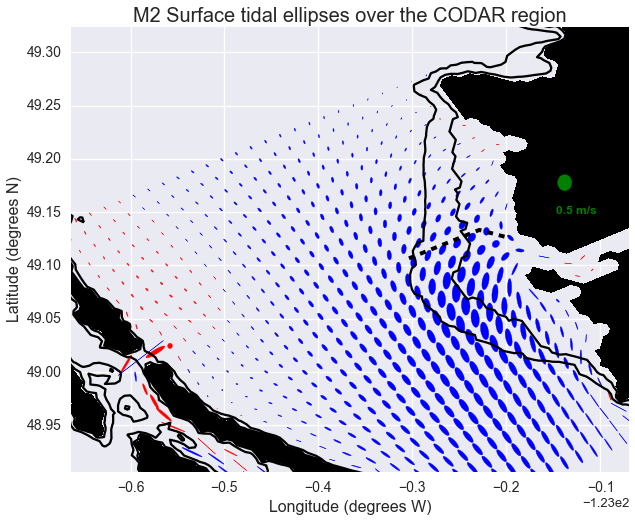

In [205]:
fig = plot_CODAR_ellipse(elpsM2, fB, 3, 'M2', scale = 0.03)

85


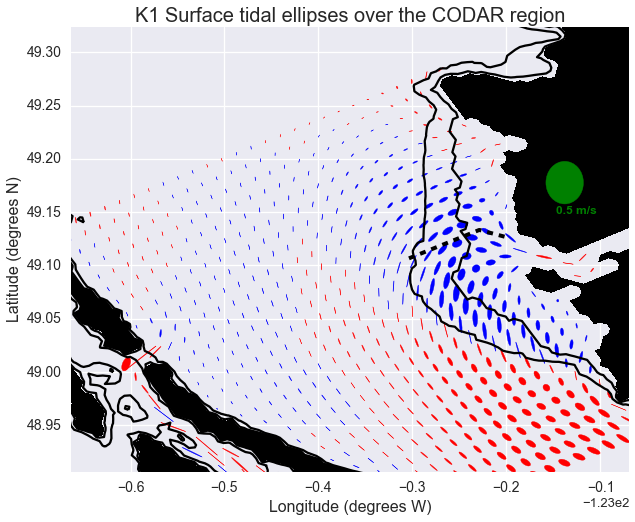

In [206]:
fig = plot_CODAR_ellipse(elpsK1, fB, 3, 'K1', scale=0.08)

#Phase plot

In [193]:
def plot_CODAR_phase(i, j, pha_m, lon_o, lat_o, pha_o, const,contour=True):
    ex=10

    #vals = params_av[jmin:jmax:4, imin:imax:4, 3]
    #valsk1 = params_av[jmin:jmax:4, imin:imax:4, 7]

    vs= np.linspace(0,360)
    palette2 = sns.hls_palette(40, l=.6, s=0.8)
    palette = sns.light_palette("navy" , 20)
    cmap1 = mcolors.ListedColormap(palette2)

    fig, [ax, ax1] = plt.subplots(1,2, figsize=(25,10))
    #Model
    if contour: 
        mesh = ax.contourf(lons[j[0]:j[-1]+1, i[0]:i[-1]+1], lats[j[0]:j[-1]+1, i[0]:i[-1]+1], pha_m, vs, cmap=cmap1, alpha = 0.8)
    else:
        mesh = ax.pcolormesh(lons[j[0]:j[-1]+1, i[0]:i[-1]+1], lats[j[0]:j[-1]+1, i[0]:i[-1]+1], pha_m, vmin=0, vmax=360, cmap=cmap1, alpha = 0.8)
    contour_interval = [-0.01, 0.01]
    ax.contourf(lons[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               lats[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               bathy.data[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],contour_interval,colors='black')

    ax.contour(lons[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               lats[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               bathy.data[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],[5],colors='black')
    viz_tools.set_aspect(ax)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Longitude',**axisfont)
    ax.set_ylabel('Latitude',**axisfont)
    ax.set_title('{} phase through the CODAR region'.format(const), **font)

    #Observations
    cbar = plt.colorbar
    if contour: 
        mesh = ax1.contourf(lon_o, lat_o, pha_o, vs, cmap=cmap1, alpha = 0.8)
    else:
        mesh = ax1.pcolormesh(lon_o, lat_o, pha_o, vmin=0, vmax=360, cmap=cmap1, alpha = 0.8)
    cbar = fig.colorbar(mesh)
    contour_interval = [-0.01, 0.01]
    ax1.contourf(lons[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               lats[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               bathy.data[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],contour_interval,colors='black')

    ax1.contour(lons[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               lats[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],
               bathy.data[j[0]-ex:j[-1]+ex, i[0]-ex:i[-1]+ex],[5],colors='black')
    viz_tools.set_aspect(ax1)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    cbar.set_label('Phase (deg)',**axisfont)
    ax1.set_xlabel('Longitude',**axisfont)
    ax1.set_ylabel('Latitude',**axisfont)
    ax1.set_title('{} phase observation through the CODAR region'.format(const),**font)
    ax.plot(-123-np.array([18.2,  13.7,  12])/60.,49+np.array([6.4,  8, 7.6])/60.,'--k',lw=2);
    ax1.plot(-123-np.array([18.2,  13.7,  12])/60.,49+np.array([6.4,  8, 7.6])/60.,'-k',lw=2); 
    #Plotting the CODAR stations
    lat_i = 49.211503
    lon_i = -123.202459
    j_i, i_i  = tidetools.find_closest_model_point(lon_i, lat_i, lons, lats, bathy, allow_land=True)
    lat_w = 49.018333
    lon_w = -123.172083
    j_w, i_w  = tidetools.find_closest_model_point(lon_w, lat_w, lons, lats, bathy, allow_land=True)
    for axes in [ax,ax1]:
        axes.plot(lon_i, lat_i, marker='D', color='Green',markersize=10, markeredgewidth=2)
        bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
        axes.annotate('Iona', (lon_i, lat_i + 0.02), fontsize=15,color='black', bbox=bbox_args)

        axes.plot(lon_w, lat_w, marker='D', color='Green',markersize=10, markeredgewidth=2)
        bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
        axes.annotate('Westshore', (lon_w +0.01, lat_w + 0.02), fontsize=15, color='black', bbox=bbox_args)
    return fig

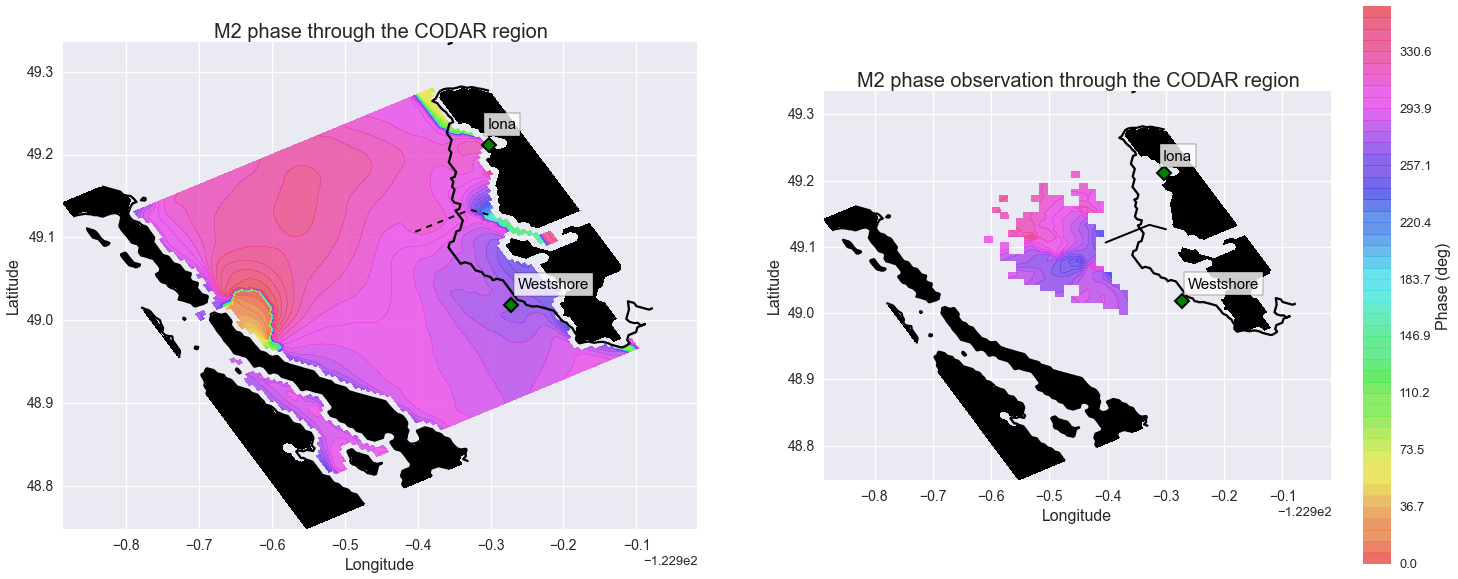

In [194]:
fig = plot_CODAR_phase(i, j, phaM, lonall, latall, phaM2, 'M2',contour=True)

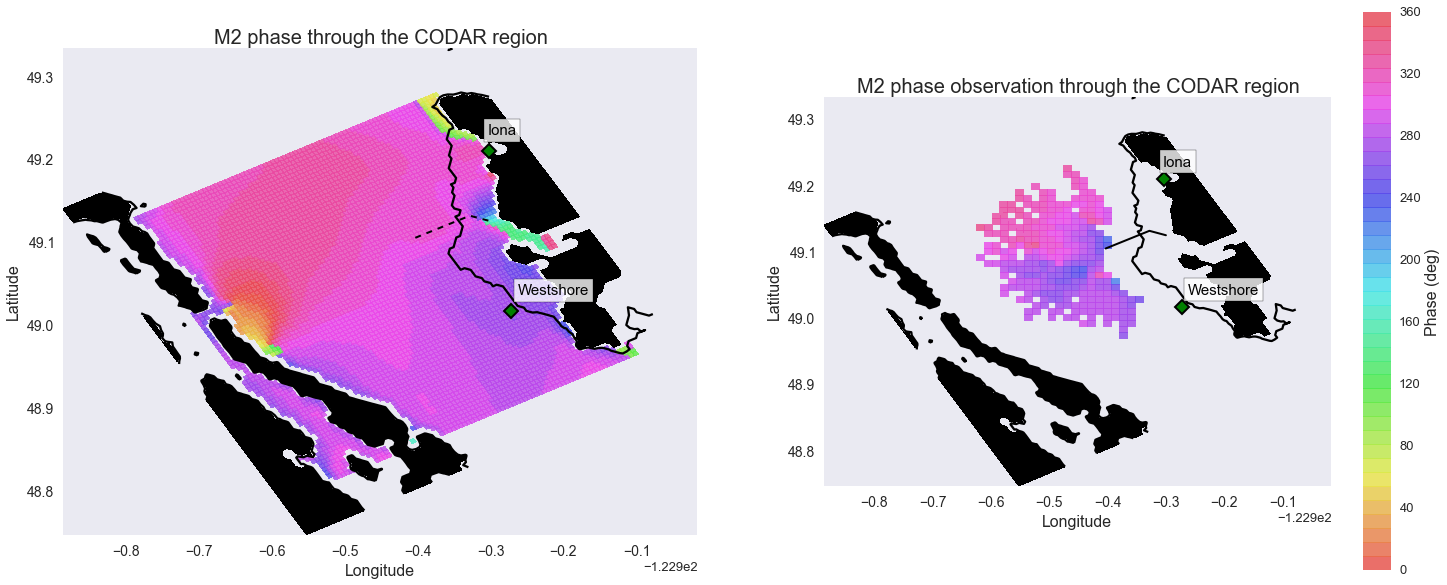

In [195]:
fig = plot_CODAR_phase(i, j, phaM, lonall, latall, phaM2, 'M2', contour=False)

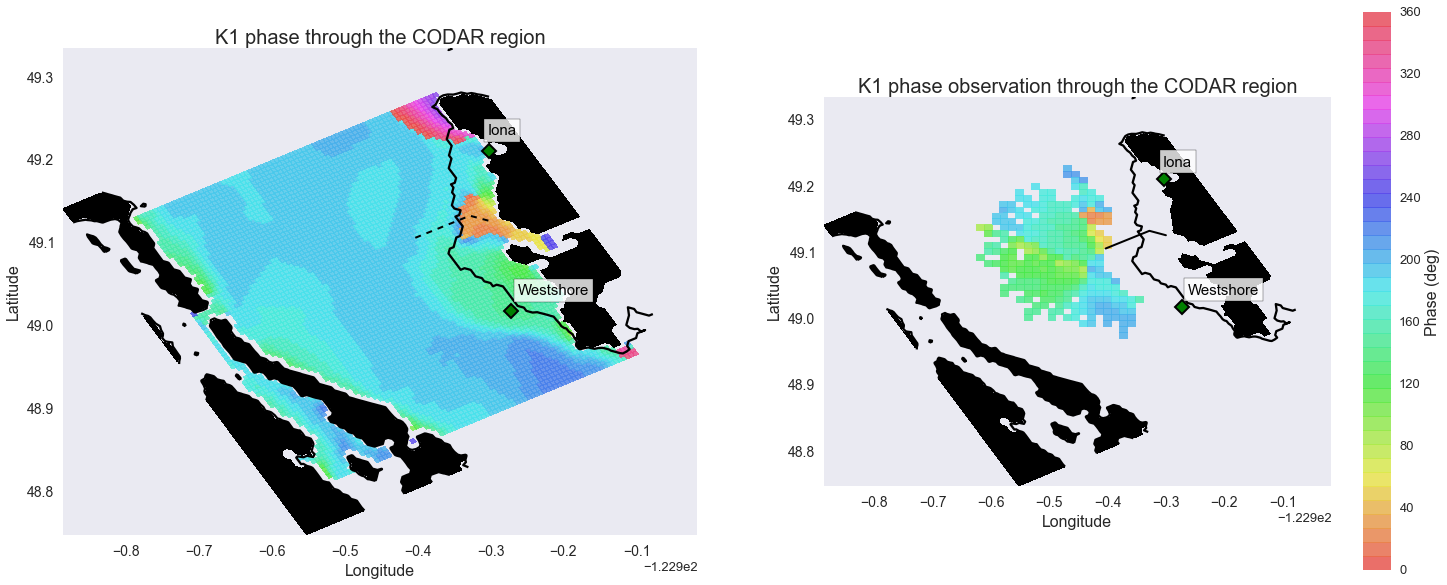

In [196]:
fig = plot_CODAR_phase(i, j, phaK, lonall, latall, phaK1, 'K1', contour=False)

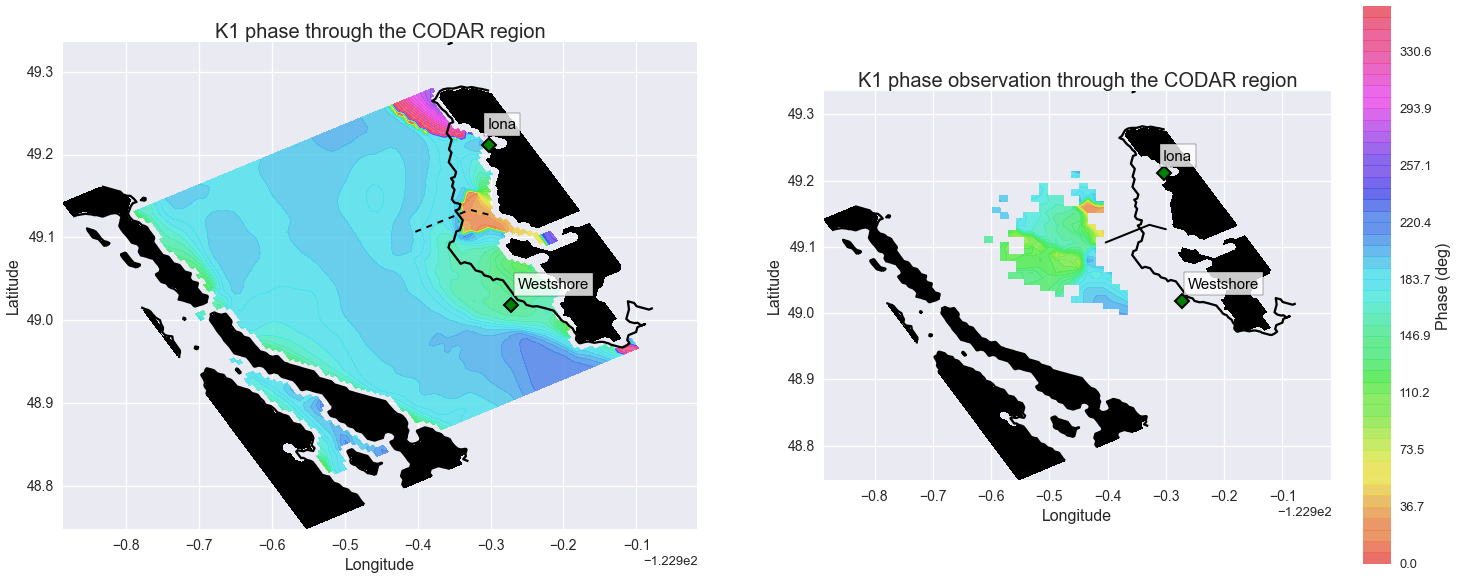

In [197]:
fig = plot_CODAR_phase(i, j, phaK, lonall, latall, phaK1, 'K1', contour=True)